In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as ipw

Define functions for plotting with plotly + ipywidgets

In [2]:
def group_then_plot_by_group(
    df_base: pd.DataFrame,
    groupby_col: str,
    index_col: str,
    values_col: str,
    labels: dict = {},
    title: str = '',
    layout: dict = {},
    show_fig: bool = True
) -> None:
    index_vals = sorted(list(set(df_base[index_col])))
    groups = df_base.groupby(groupby_col)
    grouped_df = pd.DataFrame({index_col: index_vals})
    
    for name, df in groups:
        col_vals = []
        df = df.set_index(index_col)
        for idx in index_vals:
            if idx in df.index:
                col_vals.append(df.loc[idx][values_col])
            else:
                col_vals.append(np.nan)
        grouped_df[name] = col_vals
        
    fig = px.line(
        grouped_df,
        x=index_col,
        y=[col for col in grouped_df.columns if col != index_col],
        labels=labels,
        title=title
    )
    
    if len(layout) > 0:
        fig.update_layout(**layout)
        
    fig.update_yaxes(range = [0,100])
     
    fig = go.FigureWidget(fig)
    
    if show_fig:
        fig.show(renderer="svg")
        
    return fig


def make_subplots_by_region(
    df_with_regions: pd.DataFrame, 
    region_col: str, 
    groupby_col, 
    index_col,
    values_col,
    labels: dict = {},
    title: str = '',
    layout: dict = {}
):
    grouped_regional_dfs = df_with_regions.groupby(region_col)
    num_regions = len(grouped_regional_dfs)
    rows = []
    
    for row_col_index, (region, region_specific_df) in enumerate(grouped_regional_dfs):
        if row_col_index == 0:
            row = []
        elif row_col_index % 1 == 0:
            rows.append(ipw.HBox(row))
            row = []
            
        fig = group_then_plot_by_group(
            df_base=region_specific_df,
            groupby_col=groupby_col,
            index_col=index_col,
            values_col=values_col,
            labels=labels,
            title=region + ': ' + title,
            layout=layout,
            show_fig=True
        )
        row.append(fig)
        
    rows.append(ipw.HBox(row))
    subplots = ipw.VBox(rows)
    
    return subplots

## Share of individuals using the Internet

In [3]:
df_internet = pd.read_csv('share-of-individuals-using-the-internet.csv')
df_internet

,Entity,Code,Year,Individuals using the Internet (% of population)
0,Afghanistan,AFG,1990,0.000000
1,Afghanistan,AFG,2001,0.004723
2,Afghanistan,AFG,2002,0.004561
3,Afghanistan,AFG,2003,0.087891
4,Afghanistan,AFG,2004,0.105809
...,...,...,...,...
6051,Zimbabwe,ZWE,2012,12.000000
6052,Zimbabwe,ZWE,2013,15.500000
6053,Zimbabwe,ZWE,2014,16.364740
6054,Zimbabwe,ZWE,2015,22.742818


In [4]:
print('Number of countries: ' + str(len(list(set(df_internet['Entity'])))))

Number of countries: 258


There are many countries, which overcrowds the line plot, so I decided to split by region. I used the (tab-separated) table mapping countries to regions from [the International Telecommunications Union](https://meta.wikimedia.org/wiki/List_of_countries_by_regional_classification). I loaded them into a CSV (rather, TSV) file, and merged with the Share Of Individuals Using The Internet CSV file.

In [5]:
df_region = pd.read_csv('country_regions.csv', sep='\t')
df_region.head()

,Country,Region,Hemisphere
0,Andorra,Europe,Global North
1,United Arab Emirates,Middle east,Global South
2,Afghanistan,Asia & Pacific,Global South
3,Antigua and Barbuda,South/Latin America,Global South
4,Anguilla,South/Latin America,Global South


In [6]:
df = pd.merge(df_internet, df_region, how='left', left_on='Entity', right_on='Country')
df['Region'] = df['Region'].fillna('Misc.')
df['Hemisphere'] = df['Hemisphere'].fillna('Misc.')
df.head()

,Entity,Code,Year,Individuals using the Internet (% of population),Country,Region,Hemisphere
0,Afghanistan,AFG,1990,0.000000,Afghanistan,Asia & Pacific,Global South
1,Afghanistan,AFG,2001,0.004723,Afghanistan,Asia & Pacific,Global South
2,Afghanistan,AFG,2002,0.004561,Afghanistan,Asia & Pacific,Global South
3,Afghanistan,AFG,2003,0.087891,Afghanistan,Asia & Pacific,Global South
4,Afghanistan,AFG,2004,0.105809,Afghanistan,Asia & Pacific,Global South


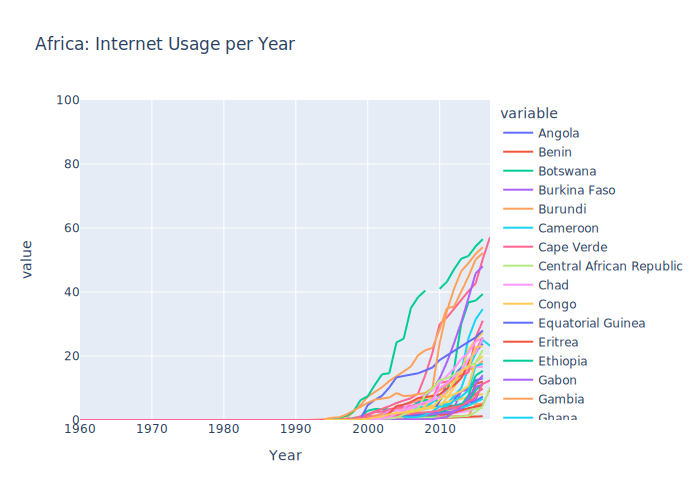

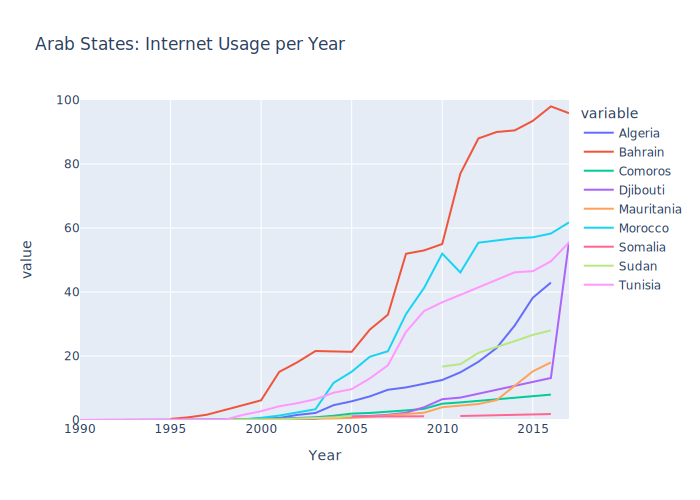

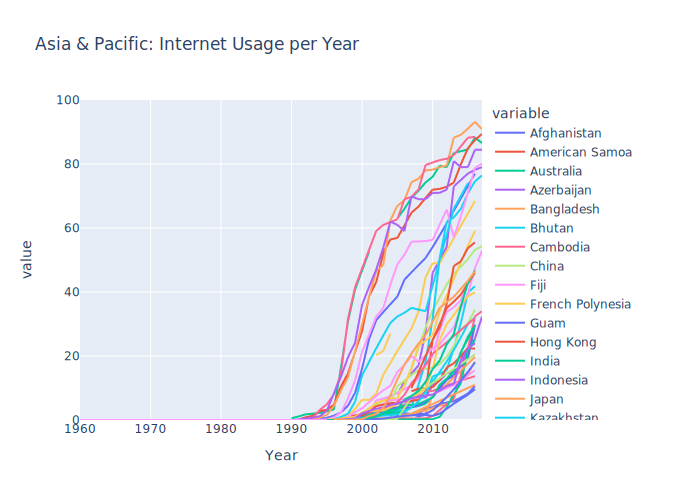

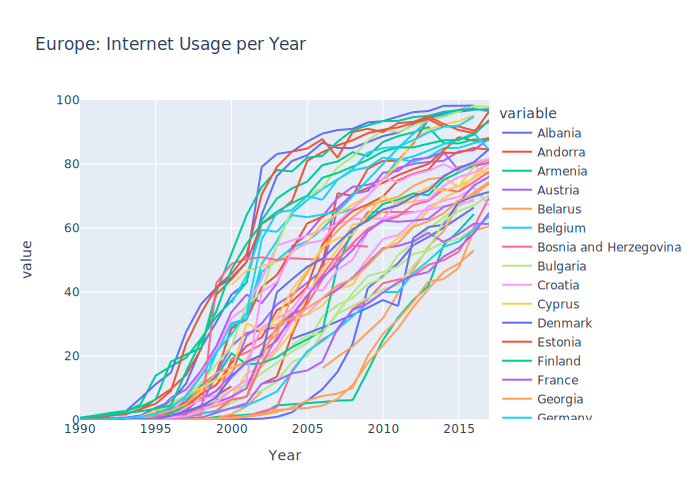

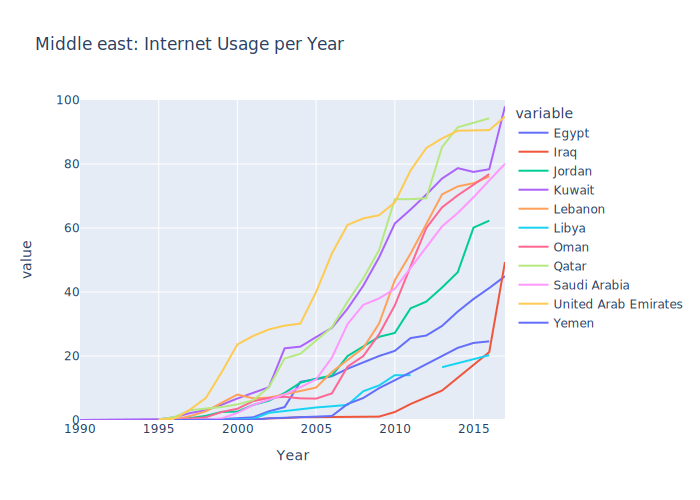

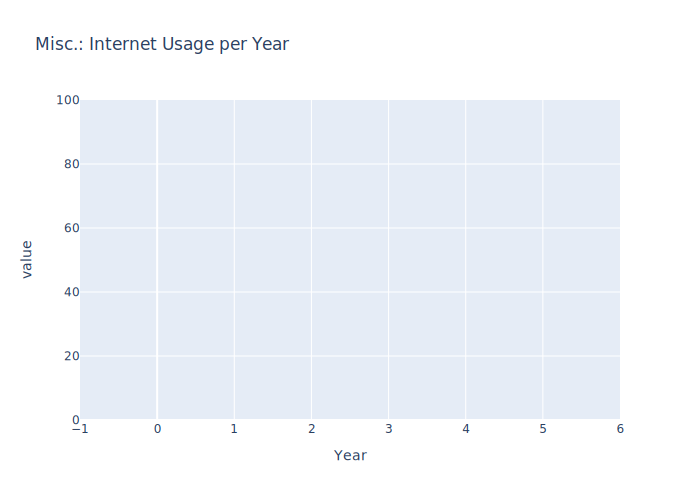

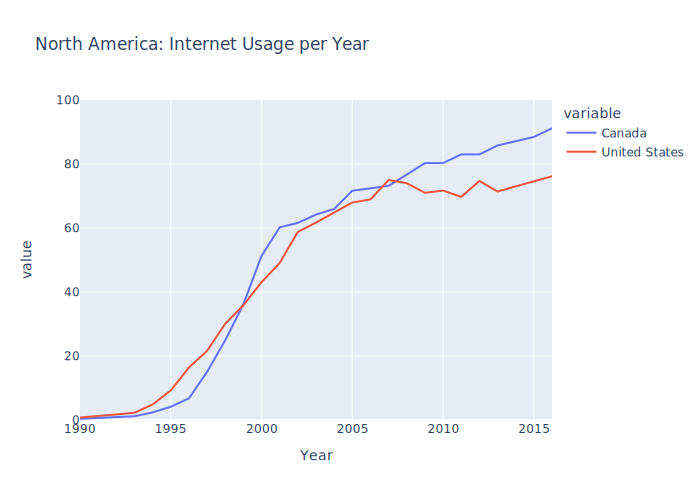

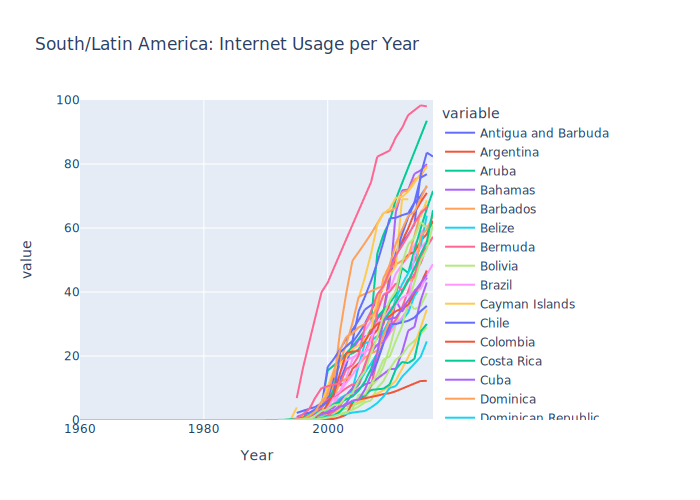

    'data': [{'hovertemplate': 'variable=Angola<br>Year=%{x}<br>v…

In [7]:
fig = make_subplots_by_region(
    df_with_regions=df,
    region_col='Region',
    groupby_col='Country',
    index_col='Year',
    values_col='Individuals using the Internet (% of population)',
    labels={},
    title='Internet Usage per Year',
    layout={}
)

fig

## Cell Phone Usage

In [17]:
df_phone = pd.read_csv('cell_phones_per_100_people.csv')
df_phone

,country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,35.0,45.8,49.2,52.1,55.2,57.3,61.1,65.9,59.1,59.4
1,Albania,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,91.3,106.0,120.0,127.0,116.0,118.0,117.0,126.0,94.2,91.3
2,Algeria,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,91.1,97.1,100.0,104.0,111.0,109.0,116.0,111.0,112.0,109.0
3,Andorra,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,77.6,77.7,77.5,79.1,83.6,91.4,98.5,104.0,107.0,114.0
4,Angola,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,40.3,49.8,50.9,51.1,52.2,49.8,45.1,44.7,43.1,46.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Venezuela,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,98.0,99.6,104.0,104.0,102.0,96.7,92.5,83.3,71.8,58.1
190,Vietnam,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,127.0,143.0,147.0,136.0,148.0,130.0,129.0,127.0,147.0,141.0
191,Yemen,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,47.9,49.0,56.8,67.0,66.2,56.7,60.5,55.2,53.7,NaN
192,Zambia,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,40.0,58.2,72.8,69.6,65.7,72.8,73.4,79.7,89.2,96.4


In [18]:
import math

def typesafe_log(element, base=10):
    try:
        return math.log(float(str(element)), base)
    except:
        return element

In [19]:
# df_transformed = df_phone.applymap(lambda x: typesafe_log(x, 10))
df_transformed = df_phone
df_transformed

,country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,35.0,45.8,49.2,52.1,55.2,57.3,61.1,65.9,59.1,59.4
1,Albania,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,91.3,106.0,120.0,127.0,116.0,118.0,117.0,126.0,94.2,91.3
2,Algeria,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,91.1,97.1,100.0,104.0,111.0,109.0,116.0,111.0,112.0,109.0
3,Andorra,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,77.6,77.7,77.5,79.1,83.6,91.4,98.5,104.0,107.0,114.0
4,Angola,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,40.3,49.8,50.9,51.1,52.2,49.8,45.1,44.7,43.1,46.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Venezuela,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,98.0,99.6,104.0,104.0,102.0,96.7,92.5,83.3,71.8,58.1
190,Vietnam,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,127.0,143.0,147.0,136.0,148.0,130.0,129.0,127.0,147.0,141.0
191,Yemen,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,47.9,49.0,56.8,67.0,66.2,56.7,60.5,55.2,53.7,NaN
192,Zambia,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,40.0,58.2,72.8,69.6,65.7,72.8,73.4,79.7,89.2,96.4


In [20]:
df = pd.merge(df_transformed, df_region, how='left', left_on='country', right_on='Country')
df['Region'] = df['Region'].fillna('Misc.')
df['Hemisphere'] = df['Hemisphere'].fillna('Misc.')
df

,country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2013,2014,2015,2016,2017,2018,2019,Country,Region,Hemisphere
0,Afghanistan,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,52.1,55.2,57.3,61.1,65.9,59.1,59.4,Afghanistan,Asia & Pacific,Global South
1,Albania,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,127.0,116.0,118.0,117.0,126.0,94.2,91.3,Albania,Europe,Global North
2,Algeria,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,104.0,111.0,109.0,116.0,111.0,112.0,109.0,Algeria,Arab States,Global South
3,Andorra,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,79.1,83.6,91.4,98.5,104.0,107.0,114.0,Andorra,Europe,Global North
4,Angola,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,51.1,52.2,49.8,45.1,44.7,43.1,46.6,Angola,Africa,Global South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Venezuela,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,104.0,102.0,96.7,92.5,83.3,71.8,58.1,Venezuela,South/Latin America,Global South
190,Vietnam,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,136.0,148.0,130.0,129.0,127.0,147.0,141.0,Vietnam,Asia & Pacific,Global South
191,Yemen,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,67.0,66.2,56.7,60.5,55.2,53.7,NaN,Yemen,Middle east,Global South
192,Zambia,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,69.6,65.7,72.8,73.4,79.7,89.2,96.4,Zambia,Africa,Global South


In [21]:
transposed = df_transformed.T
cols = transposed.iloc[0]
transposed = transposed[1:]
transposed.columns = cols
transposed.index.names = ['Year']
transposed.tail()

country,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Year,,,,,,,,,,,,,,,,,,,,,
2015,57.3,118.0,109.0,91.4,49.8,188.0,144.0,118.0,108.0,155.0,...,120.0,119.0,151.0,70.4,64.5,96.7,130.0,56.7,72.8,92.3
2016,61.1,117.0,116.0,98.5,45.1,190.0,146.0,117.0,109.0,127.0,...,119.0,123.0,149.0,74.0,78.5,92.5,129.0,60.5,73.4,91.8
2017,65.9,126.0,111.0,104.0,44.7,193.0,141.0,118.0,108.0,123.0,...,119.0,123.0,148.0,75.9,79.9,83.3,127.0,55.2,79.7,99.0
2018,59.1,94.2,112.0,107.0,43.1,NaN,132.0,121.0,111.0,124.0,...,118.0,129.0,150.0,71.5,85.9,71.8,147.0,53.7,89.2,89.4
2019,59.4,91.3,109.0,114.0,46.6,NaN,131.0,122.0,111.0,120.0,...,NaN,NaN,138.0,101.0,88.4,58.1,141.0,NaN,96.4,90.1


In [22]:
region_to_country_mapping = {
    r: [] for r in list(set(df_region['Region']))
}

for r, c in zip(df_region['Region'], df_region['Country']):
    region_to_country_mapping[r].append(c)

    
dfs_by_region = {
    r: transposed[[
        x 
        for x in region_to_country_mapping[r] 
        if x in transposed.columns]
    ]
    for r in region_to_country_mapping.keys()
}

dfs_by_region['Europe'].tail()

country,Andorra,Albania,Armenia,Austria,Bosnia and Herzegovina,Belgium,Bulgaria,Belarus,Switzerland,Cyprus,...,Poland,Portugal,Romania,Sweden,Slovenia,San Marino,Turkey,Ukraine,Serbia,Montenegro
Year,,,,,,,,,,,,,,,,,,,,,
2015,91.4,118.0,118.0,155.0,100.0,113.0,128.0,121.0,136.0,131.0,...,143.0,113.0,116.0,129.0,114.0,110.0,93.8,142.0,103.0,161.0
2016,98.5,117.0,117.0,127.0,101.0,111.0,125.0,121.0,134.0,133.0,...,140.0,112.0,116.0,128.0,115.0,109.0,94.0,133.0,103.0,166.0
2017,104.0,126.0,118.0,123.0,103.0,99.5,120.0,121.0,131.0,136.0,...,133.0,114.0,114.0,126.0,118.0,113.0,95.9,131.0,97.6,166.0
2018,107.0,94.2,121.0,124.0,104.0,99.7,119.0,123.0,127.0,139.0,...,135.0,116.0,116.0,127.0,119.0,114.0,97.3,128.0,95.8,181.0
2019,114.0,91.3,122.0,120.0,112.0,99.7,116.0,NaN,127.0,144.0,...,138.0,116.0,117.0,126.0,121.0,114.0,96.8,131.0,96.4,183.0


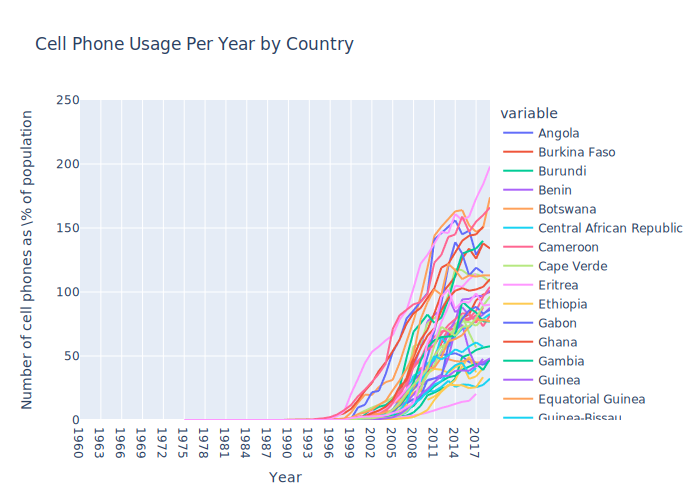

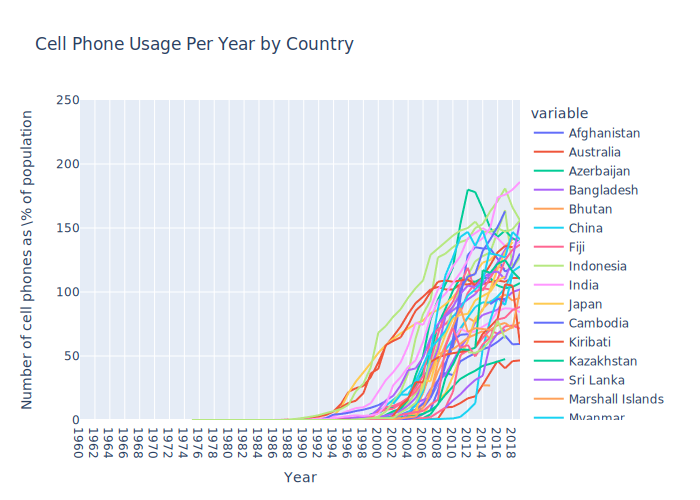

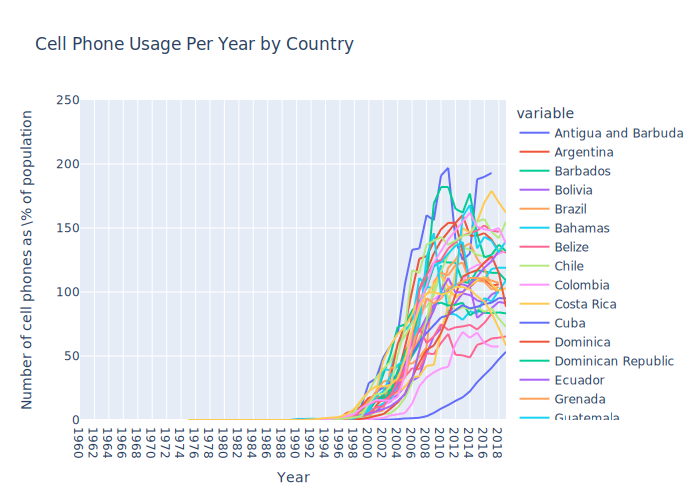

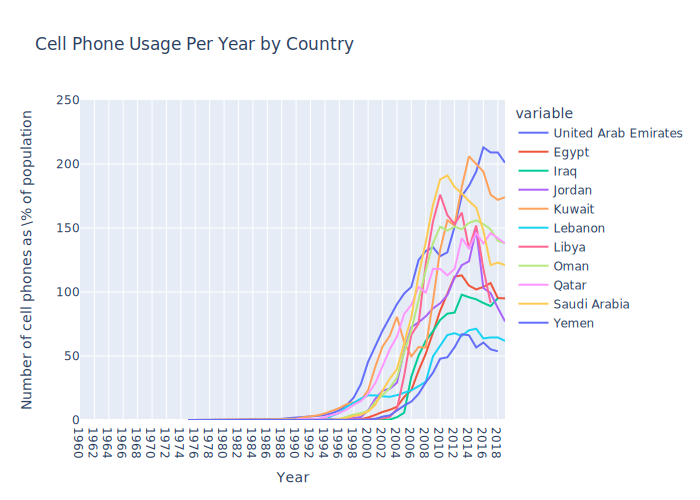

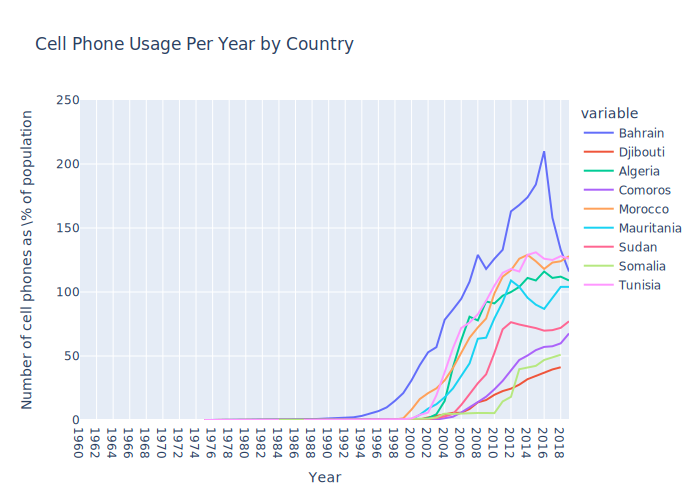

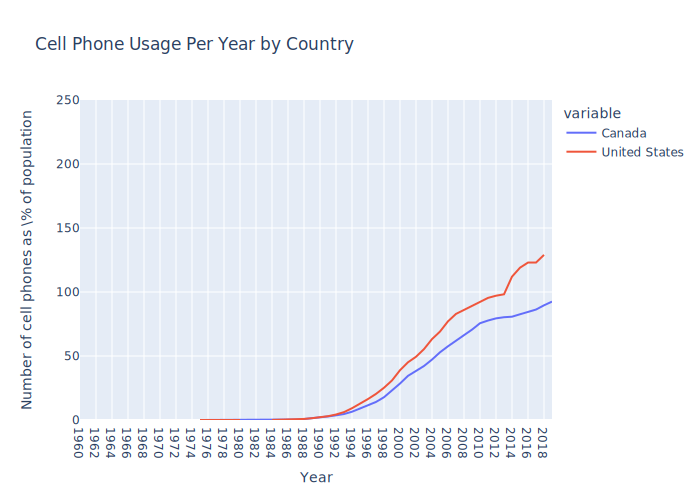

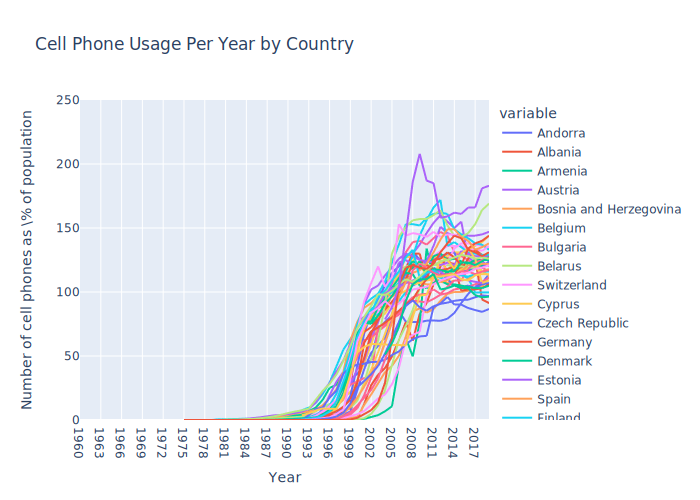

    'data': [{'hovertemplate': 'variable=Angola<br>Year=%{x}<br>v…

In [23]:
rows = []

for row_col_index, (region, regional_df) in enumerate(dfs_by_region.items()):
    if row_col_index == 0:
        row = []
    elif row_col_index % 1 == 0:
        rows.append(ipw.HBox(row))
        row = []

    fig = px.line(
        regional_df,
        x=df.index.name,
        y=[col for col in regional_df.columns if col != df.index.name],
        title='Cell Phone Usage Per Year by Country'
    )
    
    fig.update_layout(
        yaxis_title='Number of cell phones as \% of population'
    )
        
    fig.update_yaxes(range = [0, 250])
    
    fig.show(renderer='svg')
     
    fig = go.FigureWidget(fig)
    
    row.append(fig)
        
rows.append(ipw.HBox(row))
subplots = ipw.VBox(rows)

subplots
    

## Visualize hierarchical categorical data

I will visualize the latest year of cell phone usage using a sunburst plot with the path `Region` $\rightarrow$ `Hemisphere` $\rightarrow$ `Country`

In [24]:

df = df.fillna(method='ffill', axis=1)
df_latest = df[['2019', 'Region', 'Hemisphere', 'Country']]
df_latest = df_latest.rename(columns={'2019': 'Percent Phone Usage in 2019'})
df_latest

,Percent Phone Usage in 2019,Region,Hemisphere,Country
0,59.4,Asia & Pacific,Global South,Afghanistan
1,91.3,Europe,Global North,Albania
2,109.0,Arab States,Global South,Algeria
3,114.0,Europe,Global North,Andorra
4,46.6,Africa,Global South,Angola
...,...,...,...,...
189,58.1,South/Latin America,Global South,Venezuela
190,141.0,Asia & Pacific,Global South,Vietnam
191,53.7,Middle east,Global South,Yemen
192,96.4,Africa,Global South,Zambia


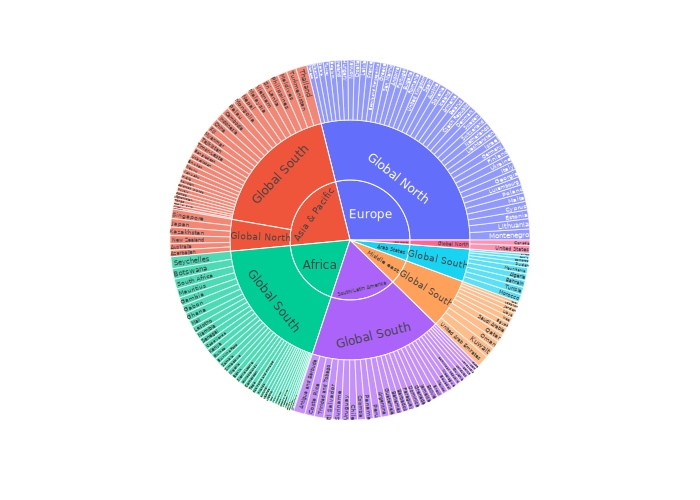

In [26]:
df_filtered = df_latest[df_latest.Region != 'Misc.']
fig = px.sunburst(df_filtered, path=['Region', 'Hemisphere', 'Country'], values='Percent Phone Usage in 2019')
fig.show(renderer='svg')

In [27]:
# interactive
fig